In [1]:
import correctionlib
import json
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename_correction = "electronRecoEfficiency.json"
#filename_physlite = "DAOD_PHYSLITE.art_split99.pool.root"
filename_physlite = "data22_13p6TeV/DAOD_PHYSLITE.30137141._000003.pool.root.1"

In [3]:
with open(filename_correction) as f:
    json_schema = json.load(f)

In [4]:
[syst["key"] for syst in json_schema["corrections"][1]["data"]["content"]["content"]]

['default', 'up', 'down']

In [5]:
# prepared by Alex Lory
# https://gitlab.cern.ch/alory/ElectronEfficiencyStudies/-/blob/master/source/MyAnalysis/data/electronRecoEfficiency.json
ceval = correctionlib.CorrectionSet.from_file(filename_correction)

From https://cms-nanoaod.github.io/correctionlib/correctionlib_tutorial.html

In [6]:
list(ceval.compound.values())

[]

In [7]:
list(ceval.keys())

['electronEfficiency', 'electronEfficiency_withETCalculation']

In [8]:
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction electronEfficiency has 4 inputs
   Input cluster_eta (real): 
   Input transverse_energy (real): 
   Input runNumber (real): run number
   Input syst (string): Systematic
Correction electronEfficiency_withETCalculation has 6 inputs
   Input cluster_eta (real): 
   Input cluster_energy (real): 
   Input electron_eta (real): 
   Input transverse_energy (real): 
   Input runNumber (real): run number
   Input syst (string): Systematic


In [9]:
ceval["electronEfficiency_withETCalculation"].evaluate(1.2, -1.0, 1.0, 1.0, 266904., "default")

1.020121521

In [10]:
from physlite_experiments.deserialization_hacks import patch_nanoevents
patch_nanoevents()

from coffea.nanoevents.schemas import PHYSLITESchema
from coffea.nanoevents import NanoEventsFactory

In [11]:
factory = NanoEventsFactory.from_root(filename_physlite, "CollectionTree", schemaclass=PHYSLITESchema)

/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping METAssoc_AnalysisMETAux. as it is it cannot be represented as an Awkward array
  warnings.warn(
/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping EventInfo_p4 as it is it cannot be represented as an Awkward array
  warnings.warn(
/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping METAssoc_AnalysisMET as it is it cannot be represented as an Awkward array
  warnings.warn(
/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping AnalysisElectrons as it is it cannot be represented as an Awkward array
  warnings.warn(
/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping GSFConversionVertices as it is it cannot be represented as an Awkward array
  warnings.warn(
/home/nikolai/code/coffea/coffea/nanoevents/mapping/uproot.py:107: UserWarning: Skipping PrimaryVerti

In [12]:
events = factory.events()

In [13]:
events.Electrons.trackParticles.pt

<Array [[], [], [], [], ... [], [], [], []] type='33417 * var * var * ?float32'>

Unfortunately correctionlib does not support jagged awkward arrays natively yet
(https://github.com/cms-nanoAOD/correctionlib/issues/125)

To make it work at least for 2D awkward arrays ("single-jagged") we can use the following decorator (it will wrap the `Correction.evaluate` function). As suggested in the mentioned PR we will flatten awkward arrays, pass the flat numpy array to correctionlib and unflatten the result again afterwards. To make this also work when we pass arrays that can be broadcasted to the right shape (e.g. the RunNumber as a 1D array with same length along the first axis) we need to broadcast these arrays explicitely before flattening, otherwise they won't match the flattened jagged arrays anymore. int, float, str are left as is, they will just work fine (and strings also seem not supported to be passed as arrays in correctionlib).

In [14]:
def ak_evaluatable(f):
    
    def evaluate(*args):
        arrays = {}
        to_broadcast = {}
        for i, array in enumerate(args):
            if isinstance(array, (int, float, str)):
                arrays[i] = array
            else:
                to_broadcast[i] = array
        broadcasted = ak.broadcast_arrays(
            *to_broadcast.values(),
            depth_limit=2, # not quite sure why i need depth_limit
        )
        counts = ak.num(broadcasted[0])
        for i, array in zip(to_broadcast, broadcasted):
            arrays[i] = ak.flatten(array)
        arrays = [arrays[i] for i in range(len(args))]
        return ak.unflatten(f(*arrays), counts)
    
    return evaluate

In addition, to use this in a less error prone way we want to have an interface where we can pass objects (that is awkward arrays with records and behavior) instead of a bag of floats.
We could do this by wrapping each correction into a light-weight "Tool":

In [15]:
class ElectronEfficiencyCorrectionTool:
    def __init__(self, filename):
        self.correction = correctionlib.CorrectionSet.from_file(filename)[
            "electronEfficiency_withETCalculation"
        ]
        self.correction_evaluate = ak_evaluatable(self.correction.evaluate)
            
    def evaluate(self, electrons, runNumber, syst="default"):
        # pick first calo cluster for each electron
        calo_cluster = electrons.caloClusters[:, :, 0]
        return self.correction_evaluate(
            calo_cluster.calEta,
            calo_cluster.calE,
            electrons.eta,
            0.0, # E_T?
            runNumber,
            syst,
        )

In [16]:
tool = ElectronEfficiencyCorrectionTool(filename_correction)

In [17]:
sfs =  {syst: tool.evaluate(events.Electrons, 266904.0, syst=syst) for syst in ["default", "up", "down"]}

In [18]:
sfs["default"]

<Array [[], [], [], [], ... [], [], [], []] type='33417 * var * float64'>

In [19]:
def plot_with_syst(field, **kwargs):
    array = ak.flatten(events.Electrons[field]).to_numpy()
    hist, edges = np.histogram(array, **kwargs)
    hists = [hist]
    for sys, sf in sfs.items():
        hist, edges = np.histogram(array, weights=ak.flatten(sf).to_numpy(), bins=edges)
        hists.append(hist)

    fig, axs = plt.subplots(nrows=2, height_ratios=[3, 1])
    ax = axs[0]
    labels = ["uncorrected"] + list(sfs.keys())
    for hist, label in zip(hists, labels):
        ax.stairs(hist, edges, label=label)
    ax.legend()
    ax = axs[1]
    for i, hist in enumerate(hists[1:]):
        hist = hist / hists[0]
        ax.stairs(hist, edges, baseline=1, color=f"C{i+1}")
        plt.errorbar
    ax.set_ylim(0.95, 1.05)
    ax.set_xlim(*axs[0].get_xlim())

/tmp/ipykernel_46003/2381123782.py:17: RuntimeWarning: invalid value encountered in divide
  hist = hist / hists[0]


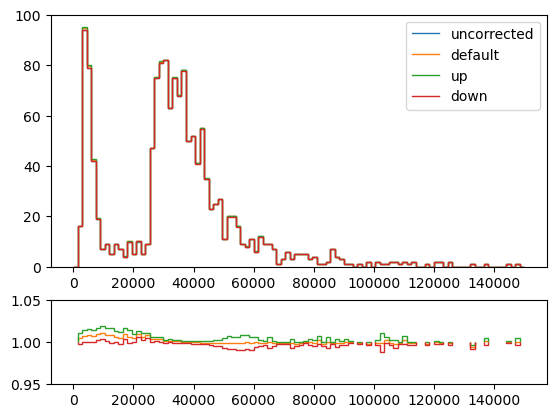

In [20]:
plot_with_syst("pt", bins=100, range=(0, 150e3))

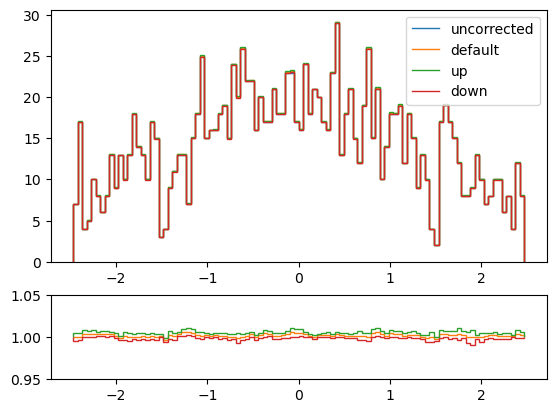

In [21]:
plot_with_syst("eta", bins=100, range=(-2.47, 2.47))